Imports & Paths

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# -------------------------------------------------------------------
# Paths (Notebook is in project/notebooks)
# -------------------------------------------------------------------
base_dir = os.getcwd()   # works in Jupyter
data_path = os.path.abspath(os.path.join(base_dir, '..', 'data'))

classified_path = os.path.join(data_path, "full_covid_abuse.csv") 

# -------------------------------------------------------------------
# Load datasets
# -------------------------------------------------------------------
classified_df = pd.read_csv(classified_path, dtype=str)

# Ensure tweet_id consistent type
classified_df["tweet_id"] = classified_df["tweet_id"].astype(str)
classified_df["is_abusive"] = (
    pd.to_numeric(classified_df["is_abusive"], errors="coerce")
    .fillna(0)
    .astype(int)
)


Counts and Summary

In [2]:
# ---------------------------------------------------------------
# Compute overall statistics
# ---------------------------------------------------------------

total = len(classified_df)
abusive_count = (classified_df["is_abusive"] == 1).sum()
non_abusive_count = (classified_df["is_abusive"] == 0).sum()

print("===== DATA SUMMARY =====")
print(f"Total tweets in dataset    : {total:,}")
print(f"Non-abusive (0) : {non_abusive_count:,}")
print(f"Abusive (1)     : {abusive_count:,}")

abusive_ratio = abusive_count / total * 100
print(f"% Abusive among labeled tweets     : {abusive_ratio:.2f}%")


===== DATA SUMMARY =====
Total tweets in dataset    : 1,884,097
Non-abusive (0) : 1,684,665
Abusive (1)     : 199,432
% Abusive among labeled tweets     : 10.59%


Bar Chart (Abusive vs Non-abusive)

C:\Users\hosse339\AppData\Local\Temp\ipykernel_29336\3629428229.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=classified_df, x="is_abusive", palette="Set2")


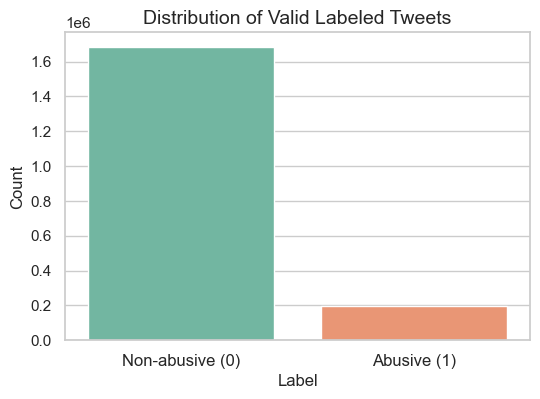

In [3]:
# ---------------------------------------------------------------
# Plot abusive vs non-abusive (valid labeled only)
# ---------------------------------------------------------------

sns.set(style="whitegrid")

plt.figure(figsize=(6,4))
sns.countplot(data=classified_df, x="is_abusive", palette="Set2")
plt.xticks([0,1], ["Non-abusive (0)", "Abusive (1)"], fontsize=12)
plt.title("Distribution of Valid Labeled Tweets", fontsize=14)
plt.xlabel("Label", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.show()


Monthly Abusive Distribution

C:\Users\hosse339\AppData\Local\Temp\ipykernel_29336\1189301571.py:8: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  classified_df["year_month"] = classified_df["created_at"].dt.to_period("M").astype(str)


Monthly abusive distribution:


,year_month,is_abusive,count
0,2020-01,0,19827
1,2020-01,1,1105
2,2020-02,0,24791
3,2020-02,1,1785
4,2020-03,0,107406
5,2020-03,1,6305
6,2020-04,0,90745
7,2020-04,1,8789
8,2020-05,0,62725
9,2020-05,1,6753


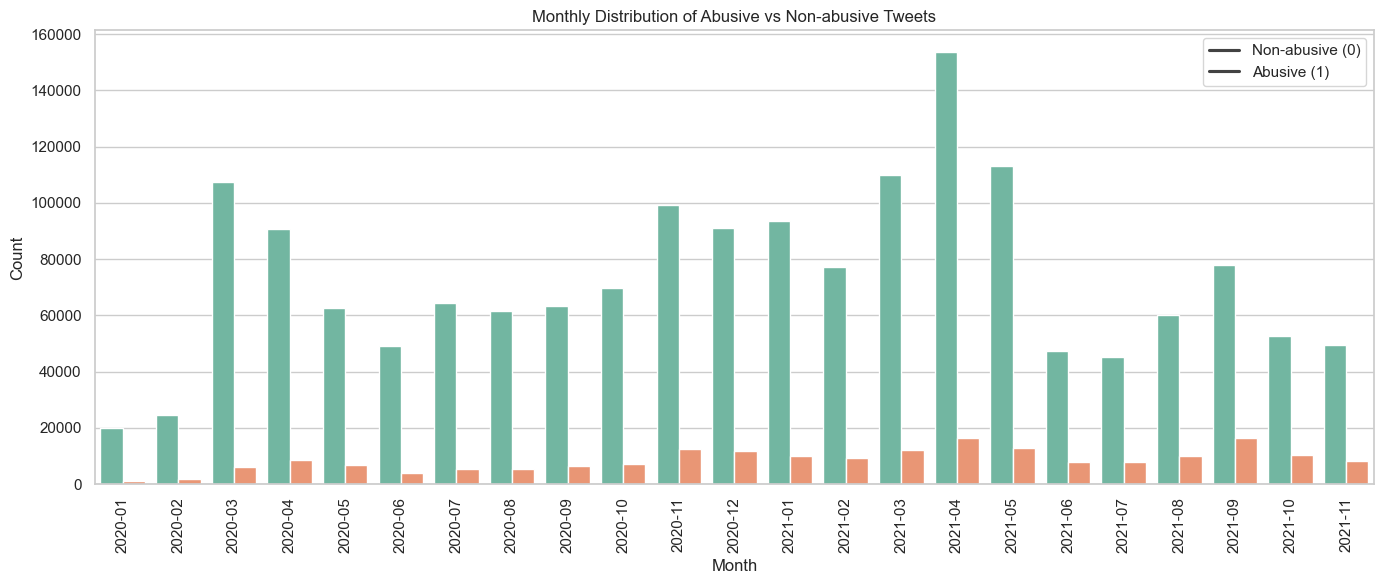

In [4]:
# ---------------------------------------------------------------
# A. Monthly abusive distribution
# ---------------------------------------------------------------
# Convert created_at to datetime
classified_df["created_at"] = pd.to_datetime(classified_df["created_at"], errors="coerce")

# Extract year-month
classified_df["year_month"] = classified_df["created_at"].dt.to_period("M").astype(str)


monthly_stats = (
    classified_df
    .groupby(["year_month", "is_abusive"])
    .size()
    .reset_index(name="count")
)

print("Monthly abusive distribution:")
display(monthly_stats.head(10))

# Plot
plt.figure(figsize=(14,6))
sns.barplot(
    data=monthly_stats,
    x="year_month",
    y="count",
    hue="is_abusive",
    palette="Set2"
)
plt.xticks(rotation=90)
plt.title("Monthly Distribution of Abusive vs Non-abusive Tweets")
plt.xlabel("Month")
plt.ylabel("Count")
plt.legend(["Non-abusive (0)", "Abusive (1)"])
plt.tight_layout()
plt.show()


Timeline of Labeling Progress (Cumulative)

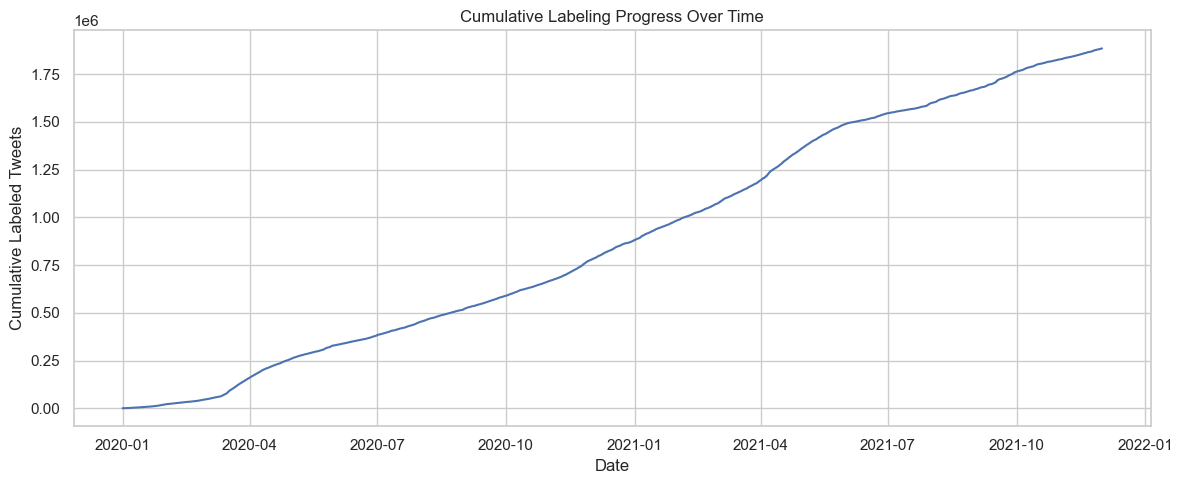

Cumulative labeling progress over time computed.


In [5]:
# ---------------------------------------------------------------
# C. Timeline of labeling progress (cumulative)
# ---------------------------------------------------------------

# Count how many tweets were labeled based on created_at
classified_df = classified_df.sort_values("created_at")
classified_df["cumulative_labeled"] = range(1, len(classified_df) + 1)

plt.figure(figsize=(12,5))
plt.plot(
    classified_df["created_at"],
    classified_df["cumulative_labeled"]
)
plt.title("Cumulative Labeling Progress Over Time")
plt.xlabel("Date")
plt.ylabel("Cumulative Labeled Tweets")
plt.tight_layout()
plt.show()

print("Cumulative labeling progress over time computed.")


Heatmap: Month × Abusive Rate

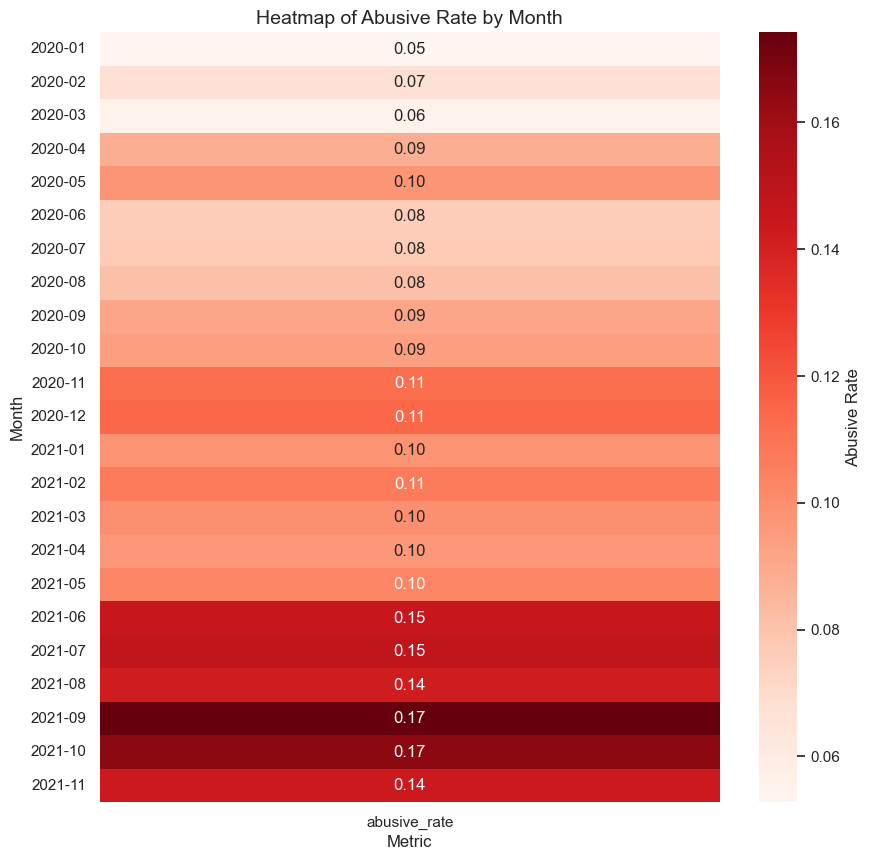

Heatmap generated.


In [6]:
# ---------------------------------------------------------------
# F. Heatmap: Month vs Abusive Rate
# ---------------------------------------------------------------

# Compute monthly abusive rate
monthly_stats = (
    classified_df.groupby(["year_month", "is_abusive"])
    .size()
    .reset_index(name="count")
    .pivot(index="year_month", columns="is_abusive", values="count")
    .fillna(0)
)

monthly_stats.columns = ["non_abusive", "abusive"]  # 0, 1
monthly_stats["abusive_rate"] = (
    monthly_stats["abusive"] / (monthly_stats["abusive"] + monthly_stats["non_abusive"])
)

# Prepare heatmap (one column: abusive rate)
heatmap_data = monthly_stats[["abusive_rate"]].copy()

# Convert to matrix form with numeric order for better visualization
heatmap_data = heatmap_data.sort_index()

plt.figure(figsize=(10, 10))
sns.heatmap(
    heatmap_data,
    annot=True,
    cmap="Reds",
    fmt=".2f",
    cbar_kws={"label": "Abusive Rate"}
)
plt.title("Heatmap of Abusive Rate by Month", fontsize=14)
plt.xlabel("Metric")
plt.ylabel("Month")
plt.show()

print("Heatmap generated.")


Normalize and Extract Terms

In [7]:
import json
from collections import Counter

# Ensure consistent type
def parse_terms(x):
    if isinstance(x, str):
        try:
            return json.loads(x)
        except:
            return []
    return x if isinstance(x, list) else []

classified_df["terms_list"] = classified_df["new_covid_terms"].apply(parse_terms)

# Flatten
all_terms = [
    term.lower().strip()
    for terms in classified_df["terms_list"]
    if isinstance(terms, list)
    for term in terms
]


Global Frequency of New COVID Terms

In [8]:
term_counts = Counter(all_terms)

# Display top 30
top_terms = term_counts.most_common(30)
display(pd.DataFrame(top_terms, columns=["term", "count"]))


,term,count
0,anti-vax,3457
1,covid19,3315
2,#covid19,3107
3,covid,2439
4,pandemic,1866
5,covidiots,1830
6,scam,1569
7,anti-mask,1520
8,no-mask,1370
9,scamdemic,1294


Monthly Dynamics of New Terms

In [9]:
# Expand per-row terms
exploded_terms = (
    classified_df
    .explode("terms_list")
    .dropna(subset=["terms_list"])
    .copy()
)

monthly_terms = (
    exploded_terms
    .groupby(["year_month", "terms_list"])
    .size()
    .reset_index(name="count")
)

print("Monthly term frequencies:")
display(monthly_terms.head(10))


Monthly term frequencies:


,year_month,terms_list,count
0,2020-01,#2019_nCov,1
1,2020-01,#2019nCoV,12
2,2020-01,#BatSoup,1
3,2020-01,#BigTelecom,1
4,2020-01,#CCP,3
5,2020-01,#CCPChina,1
6,2020-01,#China,3
7,2020-01,#Cornoavirus,1
8,2020-01,#CoronaVirus,1
9,2020-01,#CoronaVirusCanada,1


Heatmap: Top N New Terms Over Time

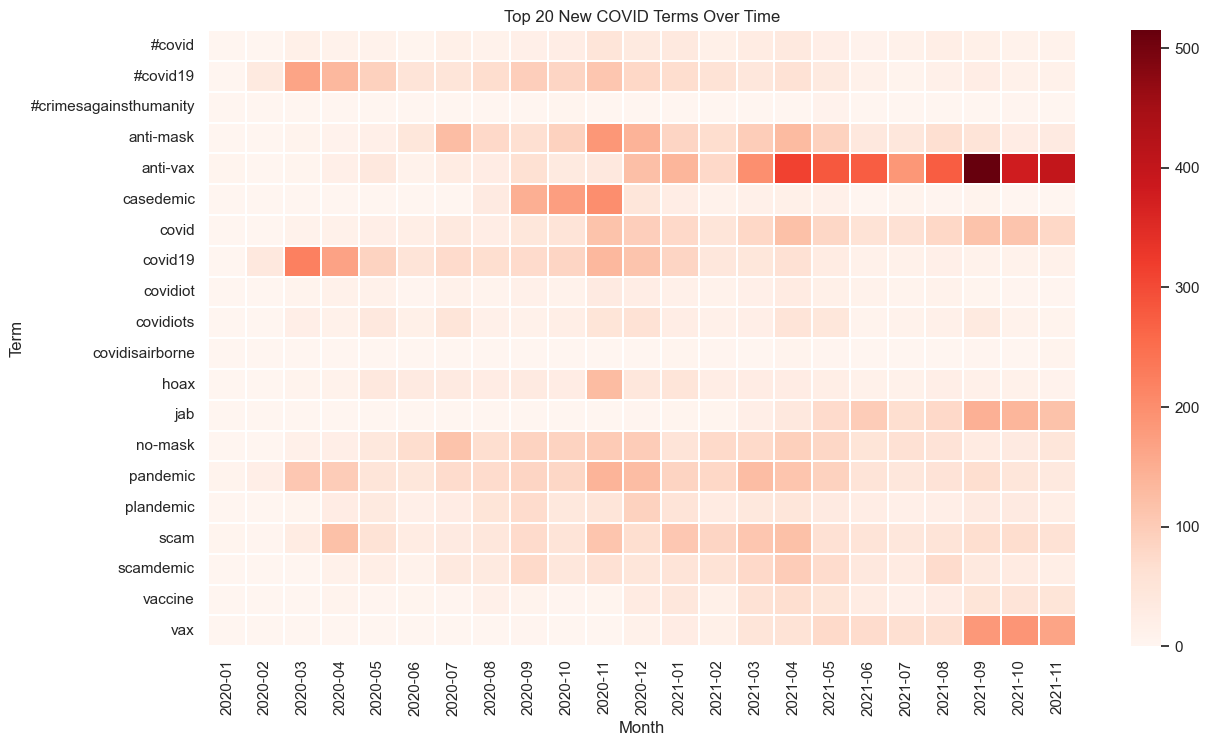

In [10]:
TOP_N = 20

# Top N terms globally
top_global_terms = [
    t for t, _ in term_counts.most_common(TOP_N)
]

# Filter
top_monthly = monthly_terms[
    monthly_terms["terms_list"].isin(top_global_terms)
]

heatmap_data = top_monthly.pivot(
    index="terms_list",
    columns="year_month",
    values="count"
).fillna(0)

plt.figure(figsize=(14, 8))
sns.heatmap(
    heatmap_data,
    cmap="Reds",
    linewidths=0.2
)
plt.title(f"Top {TOP_N} New COVID Terms Over Time")
plt.xlabel("Month")
plt.ylabel("Term")
plt.xticks(rotation=90)
plt.show()


Word Cloud

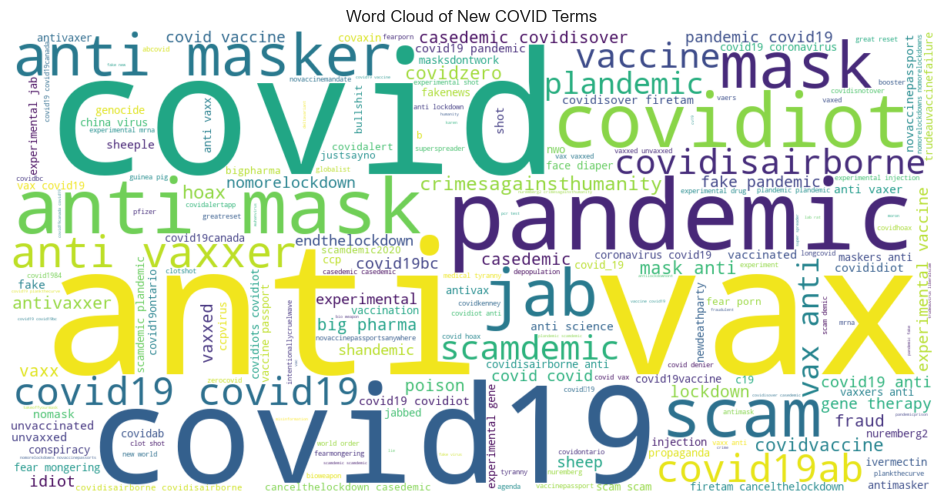

In [11]:
from wordcloud import WordCloud

wordcloud_text = " ".join(all_terms)

wc = WordCloud(
    width=1200,
    height=600,
    background_color="white"
).generate(wordcloud_text)

plt.figure(figsize=(12, 6))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of New COVID Terms")
plt.show()


Top New Terms Per Month

In [12]:
top_terms_per_month = (
    monthly_terms
    .sort_values(["year_month", "count"], ascending=[True, False])
    .groupby("year_month")
    .head(10)
)

display(top_terms_per_month)


,year_month,terms_list,count
36,2020-01,#coronavirus,23
109,2020-01,coronavirus,18
26,2020-01,#WuhanCoronavirus,16
1,2020-01,#2019nCoV,12
83,2020-01,WuhanCoronavirus,10
...,...,...,...
32651,2021-11,vaxxed,81
31882,2021-11,covid,79
30773,2021-11,#COVIDisAirborne,78
32410,2021-11,scam,59


Co-occurrence With Abusive Content

In [14]:
# ============================================================
# REPAIR is_abusive COLUMN (robust for all variants)
# ============================================================

# Identify any column that looks like an is_abusive variant
candidate_cols = [
    c for c in classified_df.columns
    if "is_abusive" in c.lower()
]

print("Candidate label columns:", candidate_cols)

# Case A: direct column exists
if "is_abusive" in classified_df.columns:
    source_col = "is_abusive"

# Case B: raw string exists
elif "is_abusive_raw" in classified_df.columns:
    source_col = "is_abusive_raw"

# Case C: merge suffixes exist
elif "is_abusive_x" in classified_df.columns:
    source_col = "is_abusive_x"

elif "is_abusive_y" in classified_df.columns:
    source_col = "is_abusive_y"

# Case D: no known variant → raise error to stop bad state
else:
    raise KeyError(
        "No is_abusive column found in classified_df. "
        "Check column names with: classified_df.columns"
    )

# Normalize and convert to numeric
classified_df["is_abusive"] = pd.to_numeric(
    classified_df[source_col],
    errors="coerce"
)

print("Created canonical is_abusive column.")


# ============================================================
# MERGE TERM LISTS BACK TO LABEL
# ============================================================

# exploded_terms should contain tweet_id + terms_list
exploded_terms = exploded_terms.merge(
    classified_df[["tweet_id", "is_abusive"]],
    on="tweet_id",
    how="left"
)

# ============================================================
# COUNT TERM FREQUENCIES
# ============================================================

abusive_term_counts = (
    exploded_terms[exploded_terms["is_abusive"] == 1]
    .groupby("terms_list")
    .size()
    .sort_values(ascending=False)
)

nonabusive_term_counts = (
    exploded_terms[exploded_terms["is_abusive"] == 0]
    .groupby("terms_list")
    .size()
    .sort_values(ascending=False)
)

print("\n=== Top terms in abusive tweets ===")
display(abusive_term_counts.head(20))

print("\n=== Top terms in non-abusive tweets ===")
display(nonabusive_term_counts.head(20))


Candidate label columns: ['is_abusive']
Created canonical is_abusive column.

=== Top terms in abusive tweets ===


terms_list
scam                      1012
COVIDIOTS                 1010
anti-vax                   895
covidiots                  509
scamdemic                  483
anti-mask                  462
#CrimesAgainstHumanity     449
covid                      401
CrimesAgainstHumanity      298
jab                        292
pandemic                   285
plandemic                  273
vax                        272
poison                     261
hoax                       245
COVIDIOT                   239
no-mask                    237
#COVID19                   226
covidiot                   219
trudeauvirusminister       197
dtype: int64


=== Top terms in non-abusive tweets ===


terms_list
anti-vax           2544
COVID19            1423
pandemic           1417
covid19            1367
#COVID19           1360
#covid19           1273
no-mask            1132
anti-mask          1042
covid               956
COVIDisAirborne     778
vax                 716
casedemic           608
plandemic           509
jab                 508
Covid               483
scamdemic           464
scam                445
#covid              400
hoax                381
vaccine             380
dtype: int64